In [ ]:
%matplotlib inline

# Plotting of electrode locations with color information on relative number of exclusions
This code uses modified methods from the python package MNE (https://github.com/mne-tools). The original classes these were taken from are indicated as comments in the respective code cells. Modifications are marked with EDIT. The rest of the code was written by Marie Bensien (mbensien@uos.de).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import mne
# path to a csv file containing two columns: electrode names and number of exclusions 
bads_stats_path='/home/marie/Documents/uni/8_SS_21/mbensienBA/data/03_statistics/01_rejected_channels.csv'
# where you want to save the plot 
plt_save_path='/home/marie/Documents/uni/8_SS_21/mbensienBA/data/04_plots/01_rejected_electrodes/03_rejects_locs.png'

In [2]:
# mne.viz.topomap 
def _draw_outlines(ax, outlines):
    """Draw the outlines for a topomap."""
    from matplotlib import rcParams
    outlines_ = {k: v for k, v in outlines.items()
                 if k not in ['patch']}
    for key, (x_coord, y_coord) in outlines_.items():
        if 'mask' in key or key in ('clip_radius', 'clip_origin'):
            continue
        ax.plot(x_coord, y_coord, color=rcParams['axes.edgecolor'],
                linewidth=1, clip_on=False, alpha=0.4) # EDIT: add alpha
    return outlines_

In [3]:
# mne.viz.utils _plot_sensors
## plot sensors lowest level 
def _plot_sensors(bad_colors, pos, info, picks, colors, bads, ch_names, title, show_names, # EDIT: added argument bad_colors
                  ax, show, kind, block, to_sphere, sphere, pointsize,
                  linewidth=2):
    """Plot sensors."""
    from matplotlib import rcParams
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 analysis:ignore
    from mne.viz.topomap import _get_pos_outlines#, _draw_outlines
    from mne.utils.check import _check_sphere
    from functools import partial
    from mne.viz.utils import _onpick_sensor, _set_window_title, _close_event, plt_show
    
    sphere = _check_sphere(sphere, info)

    edgecolors = np.repeat(rcParams['axes.edgecolor'], len(colors))
    edgecolors[bads] = 'red'
    axes_was_none = ax is None
    if axes_was_none:
        subplot_kw = dict()
        if kind == '3d':
            subplot_kw.update(projection='3d')
        fig, ax = plt.subplots(
            1, figsize=(max(rcParams['figure.figsize']),) * 2,
            subplot_kw=subplot_kw)
    else:
        fig = ax.get_figure()

    if kind == '3d':
        pointsize = 75 if pointsize is None else pointsize
        ax.text(0, 0, 0, '', zorder=1)

        ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], picker=True, c=colors,
                   s=pointsize, edgecolor=edgecolors, linewidth=linewidth)

        ax.azim = 90
        ax.elev = 0
        ax.xaxis.set_label_text('x (m)')
        ax.yaxis.set_label_text('y (m)')
        ax.zaxis.set_label_text('z (m)')
    else:  # kind in 'select', 'topomap'
        pointsize = 25 if pointsize is None else pointsize
        ax.text(0, 0, '', zorder=1)

        pos, outlines = _get_pos_outlines(info, picks, sphere,
                                          to_sphere=to_sphere)
        _draw_outlines(ax, outlines)
        pts = ax.scatter(pos[:, 0], pos[:, 1], picker=True, clip_on=False,
                         c=colors, edgecolors=edgecolors, s=pointsize,
                         lw=linewidth)
        if kind == 'select':
            fig.lasso = SelectFromCollection(ax, pts, ch_names)
        else:
            fig.lasso = None

        # Equal aspect for 3D looks bad, so only use for 2D
        ax.set(aspect='equal')
        if axes_was_none:  # we'll show the plot title as the window title
            fig.subplots_adjust(left=0, bottom=0, right=1, top=1)
        ax.axis("off")  # remove border around figure
    del sphere

    connect_picker = True
    if show_names:
        if isinstance(show_names, (list, np.ndarray)):  # only given channels
            # EDIT 
            if bad_colors:
                ch_names_casefold = []
                for name in ch_names:
                    ch_names_casefold.append(name.casefold())
                indices = [list(ch_names_casefold).index(name.casefold()) for name in show_names]
            else: 
                indices = [list(ch_names).index(name) for name in show_names]
        else:  # all channels
            indices = range(len(pos))
        for idx in indices:
            this_pos = pos[idx]
            if kind == '3d':
                ax.text(this_pos[0], this_pos[1], this_pos[2], ch_names[idx])
            else:
                ax.text(this_pos[0] + 0.0045, this_pos[1], ch_names[idx],
                        ha='left', va='center', fontsize='small', fontweight='bold') # EDIT: fontsize, boldness and position
        connect_picker = (kind == 'select')
    if connect_picker:
        picker = partial(_onpick_sensor, fig=fig, ax=ax, pos=pos,
                         ch_names=ch_names, show_names=show_names)
        fig.canvas.mpl_connect('pick_event', picker)
    if axes_was_none:
        _set_window_title(fig, title)
    closed = partial(_close_event, fig=fig)
    fig.canvas.mpl_connect('close_event', closed)
    plt_show(show, block=block)
    return fig


In [4]:
## custom generator of adaptive color palette for comprehensive plotting of excluded electrodes
def get_custom_colors(picks):
    import csv
    # import meta stats
    with open(bads_stats_path, mode='r') as file:
        reader = csv.reader(file)
        bads_stats = {rows[0]:rows[10] for rows in reader}
    # delete all the entries you do not need
    not_electrodes = {'electr/subj', 'n=1', 'n=2', 'n=3', 'n_cond1', 'n_cond2', 'n_cond3'}
    for not_electrode in not_electrodes:
        bads_stats.pop(not_electrode)
    
    # find highest n of exclusions of all channels for normalizing factor of alpha value
    values = list(bads_stats.values())
    for idx in range(len(values)):
        try:
            values[idx]=int(values[idx])
        except ValueError: break
    n_max_excl = int(max(values))
    
    # build colors data for plotting: 2d array with color information for each electrode  
    # make case insesitive copy of data bc electrode names are not uniform 
    bads_stats_casefold = dict()
    for key in iter(bads_stats):
        bads_stats_casefold[key.casefold()] = bads_stats[key]
        
    colors = []
    for electrode_name in picks:
        try:
            n_exclusions = int(bads_stats_casefold[electrode_name.casefold()])
            alpha = n_exclusions/n_max_excl + 0.15 # edit this if data properties require different normalization
            if alpha > 1:
                alpha = 1
            colors.append([1, 0, 0, alpha])
        except KeyError: # if channel was not excluded at all, mark as white
            colors.append([0, 0, 0, 0])
            
    return colors

In [5]:
# custom sensor plotting, first level 
# mne.vis.utils plot_sensors
def plot_sensors(bad_colors, info, kind, ch_type, pointsize, title=None, # EDIT added argument bad_colors
                 show_names=False, ch_groups=None, to_sphere=True, axes=None,
                 block=False, show=True, sphere=None,
                 linewidth=1, verbose=None):
    
    from mne.viz.evoked import _rgb
    from mne.utils.check import (_check_option, _check_ch_locs)
    from mne.io.meas_info import Info
    from mne.io.pick import (channel_indices_by_type, _DATA_CH_TYPES_SPLIT, _contains_ch_type, channel_type)
    from mne.io.constants import FIFF
    from mne.defaults import _handle_default
    
    # Error wrangling
    _check_option('kind', kind, ['topomap', '3d', 'select'])
    if not isinstance(info, Info):
        raise TypeError('info must be an instance of Info not %s' % type(info))
    ch_indices = channel_indices_by_type(info)
    allowed_types = _DATA_CH_TYPES_SPLIT
    if ch_type is None:
        for this_type in allowed_types:
            if _contains_ch_type(info, this_type):
                ch_type = this_type
                break
        picks = ch_indices[ch_type]
    elif ch_type == 'all':
        picks = list()
        for this_type in allowed_types:
            picks += ch_indices[this_type]
    elif ch_type in allowed_types:
        picks = ch_indices[ch_type]
    else:
        raise ValueError("ch_type must be one of %s not %s!" % (allowed_types,
                                                                ch_type))
    if len(picks) == 0:
        raise ValueError('Could not find any channels of type %s.' % ch_type)

    # imports wrong method EDIT 
    # if not _check_ch_locs(info=info, picks=picks):
    #    raise RuntimeError('No valid channel positions found')

    # build head layout 
    dev_head_t = info['dev_head_t']
    chs = [info['chs'][pick] for pick in picks]
    pos = np.empty((len(chs), 3))
    for ci, ch in enumerate(chs):
        pos[ci] = ch['loc'][:3]
        if ch['coord_frame'] == FIFF.FIFFV_COORD_DEVICE:
            if dev_head_t is None:
                warn('dev_head_t is None, transforming MEG sensors to head '
                     'coordinate frame using identity transform')
                dev_head_t = np.eye(4)
            pos[ci] = apply_trans(dev_head_t, pos[ci])
    del dev_head_t

    # mark bads as red in var colors
    ch_names = np.array([ch['ch_name'] for ch in chs])
    bads = [idx for idx, name in enumerate(ch_names) if name in info['bads']]
    if ch_groups is None:
        def_colors = _handle_default('color')
        ## EDIT
        if bad_colors:
            import csv
            colors = get_custom_colors(ch_names) 
            with open(bads_stats_path, mode='r') as file:
                reader = csv.reader(file)
                show_names = {rows[0] for rows in reader}
            show_names = list(show_names)
            not_electrodes = {'electr/subj', 'n=1', 'n=2', 'n=3', 'n_cond1', 'n_cond2', 'n_cond3'}
            for not_electrode in not_electrodes:
                show_names.remove(not_electrode)
        else: 
            colors = ['red' if i in bads else def_colors[channel_type(info, pick)] for i, pick in enumerate(picks)]
    else: # grouping case 
        if ch_groups in ['position', 'selection']:
            # Avoid circular import
            from ..channels import (read_vectorview_selection, _SELECTIONS,
                                    _EEG_SELECTIONS, _divide_to_regions)

            if ch_groups == 'position':
                ch_groups = _divide_to_regions(info, add_stim=False)
                ch_groups = list(ch_groups.values())
            else:
                ch_groups, color_vals = list(), list()
                for selection in _SELECTIONS + _EEG_SELECTIONS:
                    channels = pick_channels(
                        info['ch_names'],
                        read_vectorview_selection(selection, info=info))
                    ch_groups.append(channels)
            color_vals = np.ones((len(ch_groups), 4))
            for idx, ch_group in enumerate(ch_groups):
                color_picks = [np.where(picks == ch)[0][0] for ch in ch_group
                               if ch in picks]
                if len(color_picks) == 0:
                    continue
                x, y, z = pos[color_picks].T
                color = np.mean(_rgb(x, y, z), axis=0)
                color_vals[idx, :3] = color  # mean of spatial color
        else:
            import matplotlib.pyplot as plt
            colors = np.linspace(0, 1, len(ch_groups))
            color_vals = [plt.cm.jet(colors[i]) for i in range(len(ch_groups))]
        if not isinstance(ch_groups, (np.ndarray, list)):
            raise ValueError("ch_groups must be None, 'position', "
                             "'selection', or an array. Got %s." % ch_groups)
        colors = np.zeros((len(picks), 4))
        for pick_idx, pick in enumerate(picks):
            for ind, value in enumerate(ch_groups):
                if pick in value:
                    colors[pick_idx] = color_vals[ind]
                    break
    # build plot                
    title = 'Sensor positions (%s)' % ch_type if title is None else title
    fig = _plot_sensors(bad_colors, pos, info, picks, colors, bads, ch_names, title, # EDIT added argument bad_colors
                        show_names, axes, show, kind, block,
                        to_sphere, sphere, pointsize=pointsize,
                        linewidth=linewidth)
    if kind == 'select':
        return fig, fig.lasso.selection
    return fig


<ipython-input-6-93c4039251f7>:9: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  nbp_evoked.set_montage(nbp_montage)


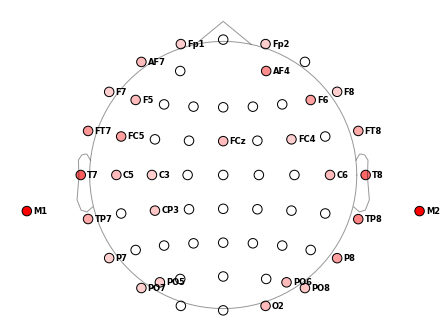

In [6]:
## custom sensor plotting main
# generate an evoked array (eeg data structure used in mne) with random data to get NBP channel location layout
nbp_montage = mne.channels.read_custom_montage(fname='04_standard-10-5-cap385_NBP.elp')
nbp_info = mne.create_info(ch_names=nbp_montage.ch_names, sfreq=250, ch_types='eeg')
n_channels = len(nbp_montage.ch_names)
rng = np.random.RandomState(0)
data = rng.normal(size=(n_channels, 1)) * 1e-6
nbp_evoked = mne.EvokedArray(data, nbp_info)
nbp_evoked.set_montage(nbp_montage)
# generate the channel layout for plotting 
nbp_layout = mne.channels.find_layout(nbp_evoked.info)

# generate topomap with adaptive coloring of electrodes
plt = plot_sensors(info=nbp_evoked.info, kind='topomap', ch_type='eeg', pointsize=90, bad_colors=True)
plt.savefig(plt_save_path, dpi=200, facecolor='white')
